# Feedforward Neural Network

In [1]:
import pickle
import time
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from matplotlib import pyplot as plt
import math

from lstm_data_prep import numpy_prep
from eval_model import accuracy, find_lens
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class FF(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.in_layer = nn.Linear(n_inputs, n_hidden)
    self.out_layer = nn.Linear(n_hidden, n_outputs)

  def forward(self, x):
    y = self.in_layer(x)
    y = self.out_layer(y)

    return y

In [21]:
class Model:
    def __init__(self, model, loss_fn, optimizer, n_input, n_hidden, n_out):
        self.model = model
        self.loss_fn = loss_fn
        self.optim = optimizer
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_out = n_out
    
    def train(self, train_data, train_labels, test_data, test_labels, n_epochs=500, rand_test=False):
        classification_acc = []
        rand_acc = []
        for time_step in range(train_data.shape[0]):
            for layer in self.model.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
            for i in range(n_epochs):
                out = self.model(train_data[time_step])

                loss = self.loss_fn(out, train_labels[time_step])
    
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()
            
            torch.save({"ff": self.model.state_dict(), "ff_optimizer": self.optim.state_dict()}, 'ff-model.pt')
            classification_acc.append(self.eval(test_data[time_step], test_labels[time_step]))

            if rand_test:
                rand_acc.append(self.rand_test(test_data[time_step], test_labels[time_step]))

        return classification_acc, rand_acc
    
    def eval(self, data, labels):
        check = torch.load("ff-model.pt")
        self.model.load_state_dict(check["ff"])
        self.optim.load_state_dict(check["ff_optimizer"])
        data = data.to(device)
        labels = labels.to(device)
        out = self.model(data)
        loss = self.loss_fn(out, labels)
        top_value, top_index = out.topk(1)

        final = torch.zeros(data.shape)
        for clip in range(data.shape[0]):
            final[clip][top_index[clip]] = 1

        correct = 0
        total = 0
        
        for j in range(out.shape[0]):
            if np.count_nonzero(labels[j].cpu().numpy())!= 0:
                if self.findIndex(1., labels[j]) == self.findIndex(torch.max(final[j]), final[j]):
                    correct += 1
                total += 1
        
        return correct / total

    def findIndex(self, val, arr):
        index = -1
        for x in range(arr.shape[0]):
            if val == arr[x].item():
                index = x
                break
        return index
    
    def random_samples(self, X, num_seq=90, pad=0.):
        X_random = []
        for i in range(X.shape[0]):
            X_batch = np.random.normal(size=X.shape[-1])
            #if X_lens[i] < num_seq:
                #X_pad = np.array([[pad]*300]*(num_seq - X_lens[i]))
                #X_batch = np.append(X_batch, X_pad, axis=0)
            X_random.append(X_batch)
        X_random = np.array(X_random)
        return X_random
    
    def rand_test(self, X, y_test, n_samples=20, percentile=90):
        rand_acc_array = []
        for sample in range(n_samples):
            X_random = torch.from_numpy(self.random_samples(X)).float().to(device)
            ff_rand_acc = self.eval(X_random, y_test)
            rand_acc_array.append(ff_rand_acc)
        
        plot = np.percentile(np.sort(np.array(rand_acc_array), axis=0), percentile, axis=0)
        return plot.squeeze(0)

In [5]:
with open('HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)

X_train, y_train, X_t, y_t = numpy_prep(TS, pad = 0.)

X_train = torch.from_numpy(X_train).float().to(device).permute(1, 0, 2)
y_train = torch.from_numpy(y_train).float().to(device).permute(1, 0, 2)
X_test = torch.from_numpy(X_t).float().to(device).permute(1, 0, 2)
y_test = torch.from_numpy(y_t).float().to(device).permute(1, 0, 2)

c:\Users\Anna\Documents\GitHub\srp-lab-notebook\hcp_data\lstm_data_prep.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_padded = paddingArr(np.array(X_arr), pad=pad)


In [22]:
EPOCHS = 500
n_input = 300
n_hidden = 103
n_output = 15
learning_rate = 1e-3

ff = FF(n_input, n_hidden, n_output).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(ff.parameters(), lr=learning_rate)

model = Model(ff, loss_fn, optimizer, n_input, n_hidden, n_output)
ff_accuracy, rand_acc = model.train(X_train, y_train, X_test, y_test, rand_test=True)


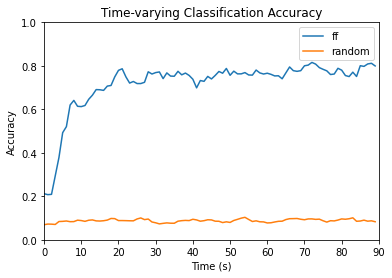

In [24]:
xAx = [i for i in range(0,90)]
plt.plot(xAx, ff_accuracy, label="ff")
plt.plot(xAx, rand_acc, label="random")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xlim(0,90)
plt.title("Time-varying Classification Accuracy")
plt.legend()
plt.show()